In [1]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며 
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1), 
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('data/labeledTrainData.tsv', delimiter='\t', quoting=3)
# 레이블이 없는 테스트 데이터
test = pd.read_csv('data/testData.tsv', delimiter='\t', quoting=3)
train.shape

/home/uss/anaconda3/envs/nlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(25000, 3)

In [4]:
train.tail(3)

,id,sentiment,review
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [5]:
test.shape

(25000, 2)

In [6]:
test.tail()

,id,review
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""","""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


In [7]:
train.columns.values

array([' id', 'sentiment', 'review'], dtype=object)

In [8]:
# test데이터에는 label인 'sentiment'가 없다. 이 데이터를 기계학습을 통해 예측해보자
test.columns.values

array(['id', 'review'], dtype=object)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 id          25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [10]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [11]:
import numpy as np
train.describe(exclude=[np.number]) #숫자값은 제외하고~

,id,review
count,25000,25000
unique,25000,24904
top,"""4580_1""","""You do realize that you've been watching the ..."
freq,1,3


In [12]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [13]:
# 리뷰에는 html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있다.
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

## 데이터 정제 (Data Cleaning and Text Preprocessing)
기계가 텍스트를 이해할 수 있도록 정제해 준다.

1. BeautifulSoup을 이용해 HTML 태그를 제거
2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
3. NLTK 데이터를 사용해 불용어(Stopword)를 제거
4. 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출

텍스트 데이터 전처리 이해하기 (출처 : 트위터 한국어 형태소 분석기 https://github.com/twitter/twitter-korean-text)

정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)

한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

토큰화 tokenization

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

어근화 stemming (입니다 -> 이다)

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋ
KoreanParticle

어구 추출 phrase extraction

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시
Introductory Presentation: Google Slides

뷰티풀숩이 설치되지 않았다면 우선 설치해 준다. 
!pip install BeautifulSoup4

In [14]:
'''
라이브러리
1. html.parser (괜찮은 속도와 관대함)

2. lxml (매우 빠르고 관대함)
pip install lxml

3. html5lib (매우 느리지만 극도로 관대)
pip install html5lib
'''

from bs4 import BeautifulSoup
example1 = BeautifulSoup(train['review'][0], "html5lib") #html5lib

In [15]:
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [18]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [19]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

In [20]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

## 불용어 제거(Stopword Removal)

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

#### NLTK data 설치

http://corazzon.github.io/nltk_data_install 

In [36]:
# 텍스트 데이터 전처리를 위해 다음을 다운로드 해야함
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/uss/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [25]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [29]:
len(stopwords.words('english'))

179

In [30]:
# stopwords 를 제거한 토큰들..
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

## 437개에서 219개로 줄어듬...

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## 스테밍(어간추출, 형태소 분석)

- 어간 추출(stemming)은 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
- "message", "messages", "messaging"과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와줌
- stemming(형태소분석) : 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생성한다.

In [31]:
# 포터 스태머의 사용예~
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [32]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [33]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [34]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

#처리후 단어..
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

# Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데

1) *배*가 맛있다. 

2) *배*를 타는 것이 재미있다. 

3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.

위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. 
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

In [37]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]
# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

# 문자열 처리

위에서 간략하게 살펴본 내용을 바탕으로 문자열을 처리해 본다.

In [38]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [39]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [40]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [41]:
"""
clean_train_reviews = []
캐글 튜토리얼에는 range가 xrange로 되어있지만 
여기에서는 python3를 사용하기 때문에 range를 사용했다.
"""
# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))
"""
하지만 위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
5000개 단위로 상태를 찍도록 개선했다.
"""
# clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1)%5000 == 0:
#         print('Review {} of {} '.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))
    
"""
그리고 코드를 좀 더 간결하게 하기 위해 for loop를 사용하는 
대신 apply를 사용하도록 개선
"""

%time train['review_clean'] = train['review'].apply(review_to_words)

"""
코드는 한 줄로 간결해 졌지만 여전히 오래 걸림
"""
# CPU times: user 1min 15s, sys: 2.3 s, total: 1min 18s
# Wall time: 1min 20s

CPU times: user 37.6 s, sys: 4.28 s, total: 41.9 s
Wall time: 41.9 s


'\n코드는 한 줄로 간결해 졌지만 여전히 오래 걸림\n'

In [42]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [43]:
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 31.2 ms, sys: 281 ms, total: 312 ms
Wall time: 15.4 s


In [44]:
%time clean_test_reviews = apply_by_multiprocessing(\
    test['review'], review_to_words, workers=4)

CPU times: user 62.5 ms, sys: 219 ms, total: 281 ms
Wall time: 13.7 s


## 워드 클라우드

- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

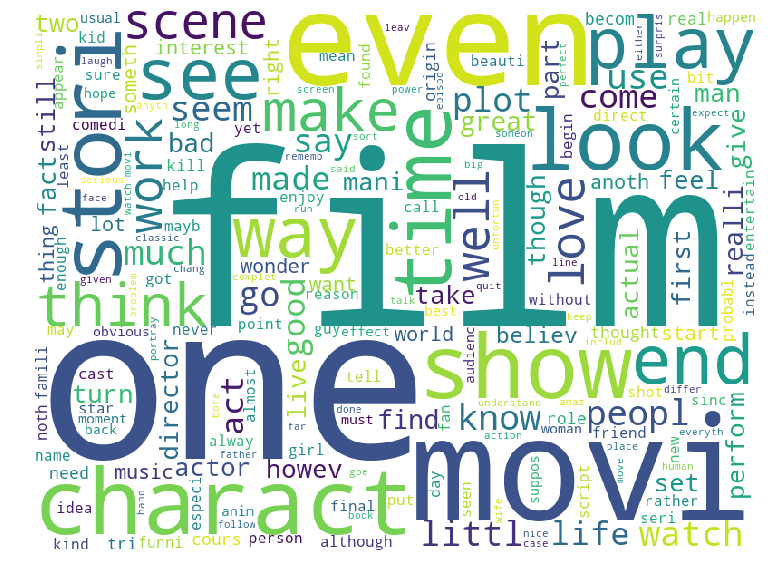

CPU times: user 13.6 s, sys: 2.83 s, total: 16.4 s
Wall time: 16.5 s


In [48]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

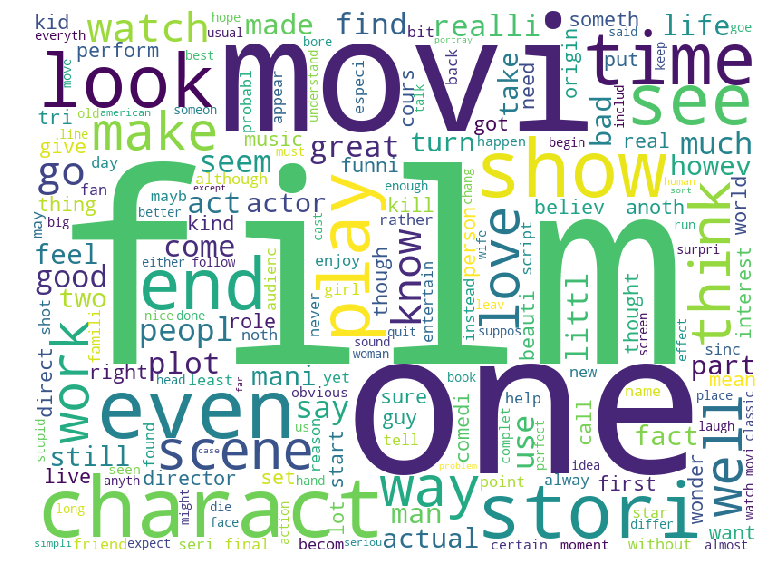

CPU times: user 13.5 s, sys: 2.31 s, total: 15.8 s
Wall time: 15.8 s


In [49]:
# 테스트 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_test_reviews))

In [50]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 6 columns):
 id               25000 non-null object
sentiment         25000 non-null int64
review            25000 non-null object
review_clean      25000 non-null object
num_words         25000 non-null int64
num_uniq_words    25000 non-null int64
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


In [52]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 89.0
리뷰별 고유 단어 평균 값 : 94.05756
리뷰별 고유 단어 중간 값 74.0


Text(0.5, 1.0, '리뷰별 고유한 단어 수 분포')

/home/uss/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/uss/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


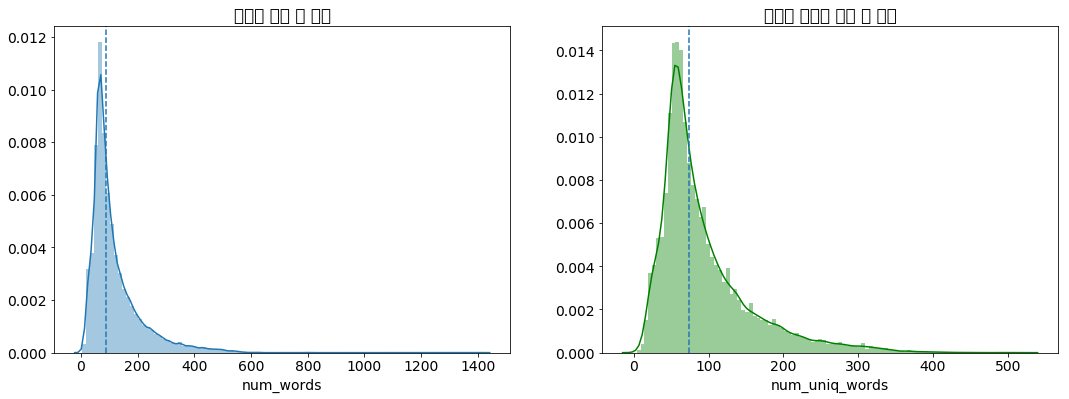

In [69]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값 :', train['num_uniq_words'].mean())
print('리뷰별 고유 단어 중간 값', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

In [1]:
import matplotlib as mpl

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  3.0.2
설치 위치:  /home/uss/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/__init__.py
설정 위치:  /home/uss/.config/matplotlib
캐시 위치:  /home/uss/.cache/matplotlib


/home/uss/anaconda3/envs/nlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
print ('설정 파일 위치: ', mpl.matplotlib_fname())

설정 파일 위치:  /home/uss/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


In [3]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체개수
print(len(font_list))

55


In [4]:
font_list[:10]

['/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf']

In [5]:
f = [f.name for f in fm.fontManager.ttflist]
print(len(font_list))
# 10개의 폰트 명 만 출력
f[:10]

55


['cmb10',
 'cmsy10',
 'DejaVu Serif',
 'cmr10',
 'STIXGeneral',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Serif',
 'cmex10',
 'STIXSizeFiveSym']

In [6]:
mpl.get_cachedir()

'/home/uss/.cache/matplotlib'

In [16]:
fm.fontManager.ttflist

[<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>,
 <Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>,
 <Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>,
 <Font 'cmr10' (cmr10.ttf) normal normal 400 normal>,
 <Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>,
 <Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>,
 <Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>,
 <Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>,
 <Font 'cmex10' (cmex10.ttf) normal normal 400 normal>,
 <Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>,
 <Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>,
 <Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>,
 <Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>,
 <Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>,
 <Font 'STIXSizeOneSym' (STIXSi

In [7]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[]

In [10]:
# 기본 설정 읽기
import matplotlib.pyplot as plt

# size, family
print('# 설정되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# 설정되어있는 폰트 사이즈
14.0
# 설정되어있는 폰트 글꼴
['Nanum Brush']


In [64]:
# serif, sans-serif, monospace
print('serif 세리프가 있는 폰트--------')
print (plt.rcParams['font.serif']) 
print('sans-serif 세리프가 없는 폰트 --------')
print (plt.rcParams['font.sans-serif']) 
print('monospace 고정폭 글꼴--------')
print (plt.rcParams['font.monospace'])

serif 세리프가 있는 폰트--------
['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
sans-serif 세리프가 없는 폰트 --------
['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
monospace 고정폭 글꼴--------
['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']


In [9]:
plt.rcParams["font.family"] = 'Nanum Brush'
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (14,4)

In [13]:
import numpy as np

data = np.random.randint(-100, 100, 50).cumsum()

In [14]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False


Text(0.5, 0, '시간(분)')

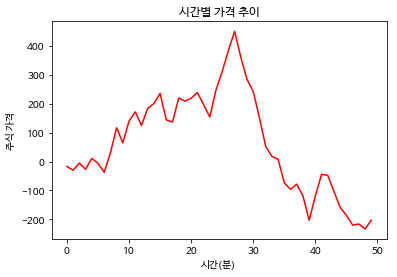

In [26]:
plt.plot(range(50), data, 'r')
mpl.rcParams['axes.unicode_minus'] = False
plt.title('시간별 가격 추이')
plt.ylabel('주식 가격')
plt.xlabel('시간(분)')


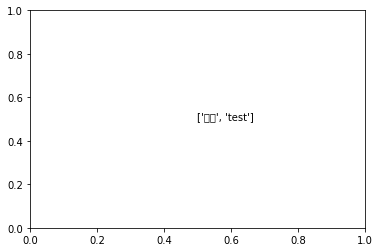

In [20]:
# 1: 한글을 그냥 써보면 박스만 그려짐.
import matplotlib.pyplot as plt
plt.text(0.5, 0.5, ['한글', 'test'])
plt.show()

In [21]:
# 2: 아래와 같이 설정해주면 한글이 잘 동작함.
# ㄴ 시스템에 install이 잘 되어 있다면 mpl.rcParams[] 설정만 하면 되는데, docker에 띄운 jupyter에서는 왠지 apt-get으로 설치한 font를 인식하지 못한다.
import matplotlib as mpl
import matplotlib.font_manager as fm

In [23]:
# 여기서 쓰려는 nanum 폰트를 잘 다운받아서 원하는 디렉토리에 넣어줌.
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

In [24]:
mpl.rcParams['font.family'] = 'NanumBarunGothic'
#mpl.rc('axes', unicode_minus=False)   # 인터넷에 이걸 지정하기도 하던데 없어도 동작은 한다.

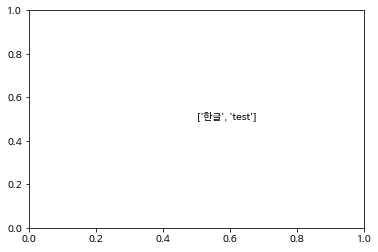

In [25]:

# 3: 다시 실행해보면 한글이 잘 보여지는걸 확인할 수 있다.
plt.text(0.5, 0.5, ['한글', 'test'])
plt.show()

In [19]:
# 1: 한글을 그냥 써보면 박스만 그려짐.
import matplotlib.pyplot as plt
plt.text(0.5, 0.5, ['한글', 'test'])
plt.show()

# 2: 아래와 같이 설정해주면 한글이 잘 동작함.
# ㄴ 시스템에 install이 잘 되어 있다면 mpl.rcParams[] 설정만 하면 되는데, docker에 띄운 jupyter에서는 왠지 apt-get으로 설치한 font를 인식하지 못한다.
import matplotlib as mpl
import matplotlib.font_manager as fm

# 여기서 쓰려는 nanum 폰트를 잘 다운받아서 원하는 디렉토리에 넣어줌.
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumBarunGothic'
#mpl.rc('axes', unicode_minus=False)   # 인터넷에 이걸 지정하기도 하던데 없어도 동작은 한다.



# 3: 다시 실행해보면 한글이 잘 보여지는걸 확인할 수 있다.
plt.text(0.5, 0.5, ['한글', 'test'])
plt.show()

# etc: 폰트 목록 확인하기.
for font in set( [ (f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name and 'Gothic' in f.name]  ) :
# print(font)

SyntaxError: unexpected EOF while parsing (<ipython-input-19-d3230d4e1569>, line 28)